Define 2 distances which we want to minimize:

1. Content Distance: the squared error between concatenated layers from the pre-trained network. So choose a layer depth and extract that layer from both the images of interest.
2. Style Distance: For each image, calculate the gram product. To do this select a layer with k feature maps. You then create a kxk matric where each element is the dot product of the corresponding feature maps. Basically, a measure of correlation. You then take the squared error between these gram products to get the distance.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import seaborn as sns
sns.set(style='ticks', palette='Set2')

import copy
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Read in data

Note: PIL images are valued between 0 to 255, when transformed to tensors, converted to 0-1. Pytorch models are trained with 0-1 tensor images.

In [3]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./images/abstract.jpg")
content_img = image_loader("./images/nature.jpg")

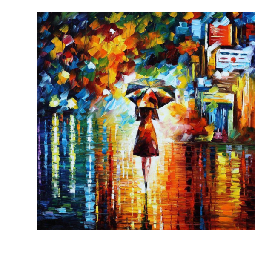

In [4]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() #clone so don't change
    image = image.squeeze(0)
    image = unloader(image)
    plt.axis('off')
    sns.despine()
    plt.imshow(image)
    plt.savefig("./images/out.png", dpi=1000)
    
imshow(style_img)

### Content Loss

In [5]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, ):
        super(ContentLoss, self).__init__()
        ## detach to prevent gradients from being calculated
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size() # batch_size (1), # feature maps, lxw of feature maps
    features = input.view(a*b, c*d) # just create one vector per feature map
    G = torch.mm(features, features.t()) # compute gram matrix
    return G.div(a*b*c*d) #normalize feature map

class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Pre-trained Net

Models come with 2 parts: Features and classifier. We just need features. We use eval b/c wont be training and some parts like dropout act differently.

VGG is normalized as followed: mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [8]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                              style_img, content_img,
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    # start a model with normalization
    model = nn.Sequential(normalization)
    
    conv_i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            conv_i += 1
            name = 'conv_{}'.format(conv_i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(conv_i)
            # inplace version doesn't play well with our losses, so replace it
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(conv_i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(conv_i)
        else:
            raise RuntimeError('Unrecog layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        if name in content_layers:
            # think always detach if don't want backprop
            # here we just want the features
            target = model(content_img).detach()
            # calculate content loss relative to content image
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(conv_i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(conv_i), style_loss)
            style_losses.append(style_loss)
    
    # loop over layers backwards to find the layer right after a style or content
    # layer and drop those since we don't need to carry them around.
    # this is why we add the content and style losses to the network
    # also why our style and content loss classes just pass what it gets forward
    # so these being in the net don't matter
    for i in range(len(model) -1, -1 ,-1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
            
    model = model[:(i+1)]
    
    return model, style_losses, content_losses

### Input Image

We need an input image to feed. To see if we can convert it to something which matches the content image and the style image. This can either be white noise or a copy of the content image. We will do the later

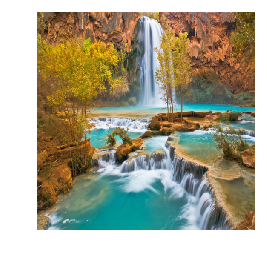

In [9]:
input_img = content_img.clone()
imshow(input_img)

## Gradient Descent (REVIEW)

In [10]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    # the model is the CNN up to the necessary conv layers
    # the losses are the loss classes initalized with the appropriate target
    # conv layers
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        # returns the update loss to the optimizer
        def closure():
            # correct the values of updated input image to be b/t 0-1
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            # since we added losses to model, they will be updated
            model(input_img)
            style_score = 0
            content_score = 0

            # we can access references to the losses from our lists
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [11]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=800)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 97.344513 Content Loss: 18.594032

run [100]:
Style Loss : 22.579805 Content Loss: 19.916662

run [150]:
Style Loss : 11.998426 Content Loss: 17.451006

run [200]:
Style Loss : 7.521138 Content Loss: 15.502533

run [250]:
Style Loss : 4.817270 Content Loss: 14.329099

run [300]:
Style Loss : 3.205785 Content Loss: 13.445590

run [350]:
Style Loss : 2.298069 Content Loss: 12.793445

run [400]:
Style Loss : 1.802079 Content Loss: 12.309561

run [450]:
Style Loss : 1.518862 Content Loss: 11.943462

run [500]:
Style Loss : 1.376415 Content Loss: 11.654619

run [550]:
Style Loss : 1.188983 Content Loss: 11.466285

run [600]:
Style Loss : 1.074302 Content Loss: 11.296025

run [650]:
Style Loss : 1.135558 Content Loss: 11.143298

run [700]:
Style Loss : 1.233841 Content Loss: 11.035079

run [750]:
Style Loss : 0.901097 Content Loss: 10.959764

run [800]:
Style Loss : 0.889393 Content Loss: 10.889429



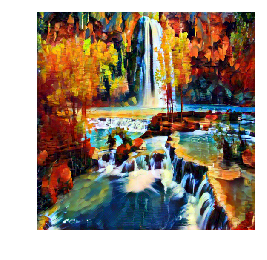

In [12]:
imshow(output, title='Output Image')